**Importing dependencies**

In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

TensorFlow 2.x selected.


**Importing the data**

In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
print(metadata)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=1.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume  

As seen from the metadata object each image is an array of size size of 28*28. The data has been split as 60k rows for training and 10k rows for validation. Since we passed as_supervised parameter as True each enrty is a tuple with the image and its corresponding output label. The data is classified amongst 10 different output labels.

**Output Labels**

In [0]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**Preprocessing**

Normalizing the data to prevent slow gradient convergence. Caching it in memory to prevent loading it from disk while training.

In [0]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# cache the dataset for better loading
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

**Visualizing the data**

We'll plot some of the grayscale values using matplotlib to get a rough view of the clothes.

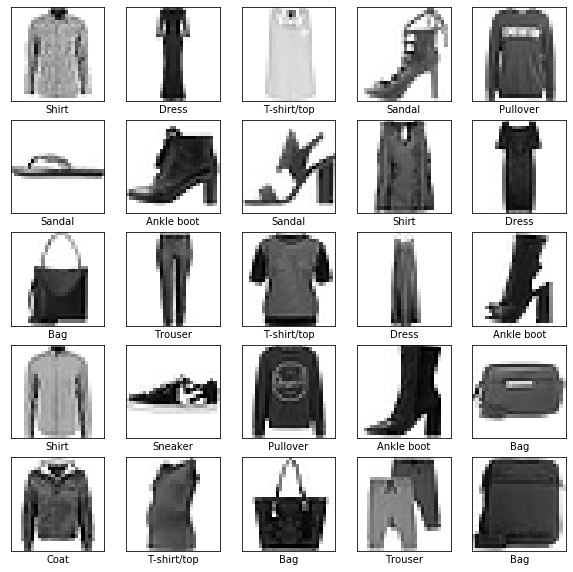

In [5]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(labels[label])
    i += 1
plt.show()

**Creating the model**

`tf.keras.Sequential` creates a neural net by taking layers from input to output sequetially. We flatten the image to send it as a single dimensional array of size 784 to the input layers.

We're using `ReLU (Rectified Linear Unit)` as an activation function allows us to deal with the non linear dependencies / interaction between inputs values
as ReLU only outputs the value when the net result produced at the node is positive. 

We're using `Softmax` as the activation of output layers which is like logistic regression but for predicting probabilistic values for multi-label classification. It provides a probability of current input Xi belonging to the class label Lj.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28, 1]),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=10, activation=tf.nn.softmax),
])

**Compiling the model**

Using `sparse_categorical_crossentropy` as the `loss` functon to measure the dissimilarity between the distribution of observed class labels and the predicted probabilities.
1. Sparse refers to using a single integer from zero to the number of classes minus one for class labels, instead of a dense one-hot encoding of the class label (e.g. { 1,0,0; 0,1,0; or 0,0,1 }).
2. Categorical refers to the possibility of having more than two classes.
3. Cross-entropy loss increases as the predicted probability diverges from the actual label.

Using TensorFlow's default `Adam` optimizer to adjust weights to reduce loss value, typical optimizer values range from 0.1 to 0.001 (lower the value more accurate the results and higher the training time)

Metrics are used to monitor the training and testing steps by specifying what parameter will be used to judge the performance of the model. The following example uses accuracy, the fraction of the images that are correctly classified.

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

**Training the model**

In [8]:
BATCH_SIZE = 32
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model_history = model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4906 - accuracy: 0.8288
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3670 - accuracy: 0.8676
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3352 - accuracy: 0.8765
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3076 - accuracy: 0.8855
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2918 - accuracy: 0.8925


**Model history**

In [9]:
print(model_history.history.keys())

dict_keys(['loss', 'accuracy'])


**Evaluating accuracy against test data**

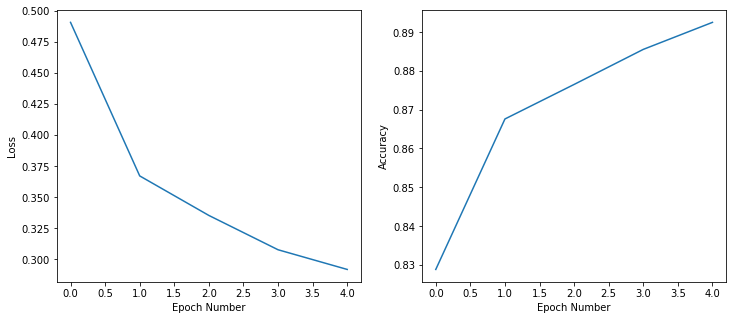

313/313 [==============================] - 3s 11ms/step - loss: 0.3511 - accuracy: 0.8733
Accuracy on test dataset: 0.8733


In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch Number')
plt.ylabel("Loss")
plt.plot(model_history.history['loss'])
plt.subplot(1,2,2)
plt.xlabel('Epoch Number')
plt.ylabel("Accuracy")
plt.plot(model_history.history['accuracy'])
plt.show()

test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

**Predictions**

In [11]:
for test_images, test_labels in test_dataset.take(10):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)
  print("Predicted: ", labels[np.argmax(predictions[0])], ", Expected: ", labels[test_labels[0]])

Predicted:  Shirt , Expected:  Shirt
Predicted:  T-shirt/top , Expected:  T-shirt/top
Predicted:  Coat , Expected:  Pullover
Predicted:  Dress , Expected:  Dress
Predicted:  T-shirt/top , Expected:  T-shirt/top
Predicted:  Shirt , Expected:  Dress
Predicted:  Sneaker , Expected:  Sneaker
Predicted:  Sandal , Expected:  Sandal
Predicted:  Ankle boot , Expected:  Ankle boot
Predicted:  Ankle boot , Expected:  Ankle boot


**Experimentation**

Training with 1 epoch

In [12]:
one_epoch_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28, 1]),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=10, activation=tf.nn.softmax),
])
one_epoch_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
one_epoch_model_history = one_epoch_model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

test_loss, test_accuracy = one_epoch_model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

Train for 1875 steps
313/313 [==============================] - 1s 3ms/step - loss: 0.4516 - accuracy: 0.8389
Accuracy on test dataset: 0.8389


Training the model for a single epoch though yielding an accuracy of over 80% still results in a higher loss value meaning some images wouldn't have been learned as better as whe ntraining over multiple epochs and the model may not perform optimally for unseen input images which may have overlapping features

Reducing the number of units in the dense layer

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6334 - accuracy: 0.7857
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4589 - accuracy: 0.8423
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4269 - accuracy: 0.8520
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4169 - accuracy: 0.8560
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4091 - accuracy: 0.8572


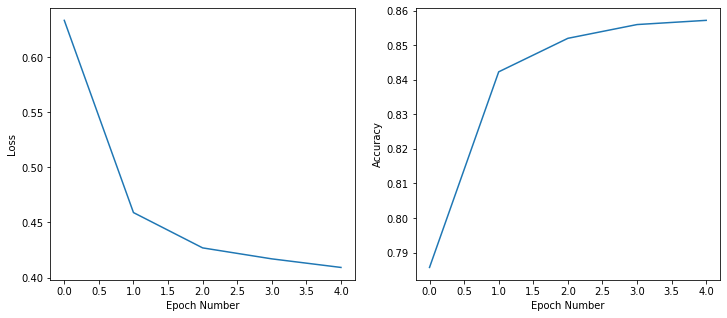

313/313 [==============================] - 1s 3ms/step - loss: 0.4407 - accuracy: 0.8456
Accuracy on test dataset: 0.8456


In [13]:
low_unit_dense_layer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28, 1]),
    tf.keras.layers.Dense(units=10, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=10, activation=tf.nn.softmax),
])
low_unit_dense_layer.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
low_unit_dense_layer_history = low_unit_dense_layer.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch Number')
plt.ylabel("Loss")
plt.plot(low_unit_dense_layer_history.history['loss'])
plt.subplot(1,2,2)
plt.xlabel('Epoch Number')
plt.ylabel("Accuracy")
plt.plot(low_unit_dense_layer_history.history['accuracy'])
plt.show()

test_loss, test_accuracy = low_unit_dense_layer.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

Reducing the number of units in the dense layer reduces the predictive power of the model

Increasing the number of units in the dense layer

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4648 - accuracy: 0.8325
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3645 - accuracy: 0.8662
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3197 - accuracy: 0.8825
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2988 - accuracy: 0.8895
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2762 - accuracy: 0.8980


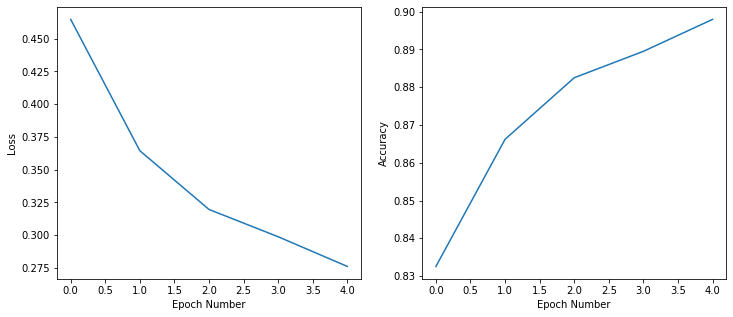

313/313 [==============================] - 1s 3ms/step - loss: 0.3630 - accuracy: 0.8672
Accuracy on test dataset: 0.8672


In [14]:
high_unit_dense_layer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28, 1]),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=10, activation=tf.nn.softmax),
])
high_unit_dense_layer.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
high_unit_dense_layer_history = high_unit_dense_layer.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch Number')
plt.ylabel("Loss")
plt.plot(high_unit_dense_layer_history.history['loss'])
plt.subplot(1,2,2)
plt.xlabel('Epoch Number')
plt.ylabel("Accuracy")
plt.plot(high_unit_dense_layer_history.history['accuracy'])
plt.show()

test_loss, test_accuracy = high_unit_dense_layer.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

Increasing the nuber of units in the dense layer to 512 increases the capacity of the model to learn better and improves the accuracy

Adding more dense layers

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4688 - accuracy: 0.8289
Epoch 2/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3592 - accuracy: 0.8684
Epoch 3/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3215 - accuracy: 0.8817
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3005 - accuracy: 0.8884
Epoch 5/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2778 - accuracy: 0.8948


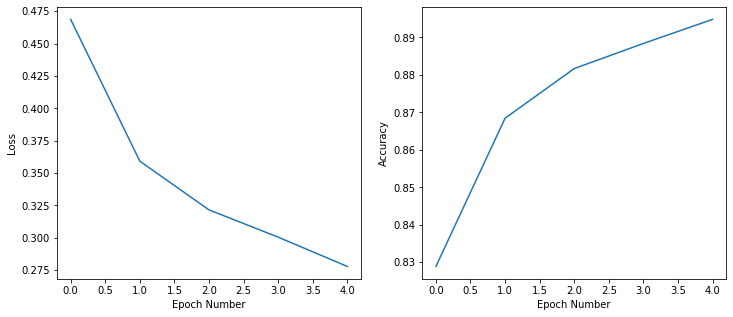

313/313 [==============================] - 1s 3ms/step - loss: 0.3481 - accuracy: 0.8752
Accuracy on test dataset: 0.8752


In [15]:
increased_dense_layers_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28, 1]),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=10, activation=tf.nn.softmax),
])
increased_dense_layers_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
increased_dense_layers_model_history = increased_dense_layers_model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch Number')
plt.ylabel("Loss")
plt.plot(increased_dense_layers_model_history.history['loss'])
plt.subplot(1,2,2)
plt.xlabel('Epoch Number')
plt.ylabel("Accuracy")
plt.plot(increased_dense_layers_model_history.history['accuracy'])
plt.show()

test_loss, test_accuracy = increased_dense_layers_model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

Training without normalization

This results in high loss and low accuracy

Sample Results:
Train for 1875 steps

Epoch 1/5
1875/1875 [==============================] - 19s 10ms/step - loss: 3.0203 - accuracy: 0.6877

Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6616 - accuracy: 0.7448

Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5820 - accuracy: 0.7889

Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5405 - accuracy: 0.8132

Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5186 - accuracy: 0.8221